##**Experiment-6**

###**Aim: Apply value iteration algorithm to specific application**

# **THEORY**

**1. Markov Decision Process (MDP):**  
    A Markov Decision Process is a mathematical framework used to model decision-making in situations where outcomes are partially random and partially under the control of a decision-maker. It consists of states, actions, transition probabilities, rewards, and a discount factor.

**2. Value Function:**  
    The value function represents the expected cumulative reward an agent can achieve from a particular state onwards, following a specific policy. It helps the agent evaluate how good it is to be in a particular state.

**3. Bellman Optimality Equation:**  
    The Bellman Optimality Equation describes a fundamental relationship between the value of a state and the values of its successor states under the optimal policy. It essentially states that the value of a state under the optimal policy equals the maximum expected return achievable from that state.

**4. Value Iteration Algorithm:**  
    Value iteration is an iterative algorithm used to find the optimal value function for an MDP. It works by iteratively improving the estimate of the optimal value function until it converges. At each iteration, the algorithm updates the value of each state based on the maximum expected return achievable from that state.

**Application to Maze Solving:**  
    In maze solving, the maze can be represented as an MDP, where each cell is a state, and the possible actions are moving in different directions (up, down, left, right). The transition probabilities are determined by the maze layout, and rewards are assigned to different states (e.g., reaching the goal yields a high reward, hitting a wall yields a negative reward). By applying the value iteration algorithm to this MDP, the agent can find the optimal policy for navigating through the maze to reach the goal while maximizing cumulative rewards.

In essence, value iteration provides a systematic way for an agent to learn the best actions to take in order to achieve its goals in a given environment. It's a powerful tool in reinforcement learning for finding optimal policies in a wide range of scenarios, including maze solving.

# **steps for value iteration **:


1. **Initialize:** Start by initializing the value of each state arbitrarily. This could be zeros for all states, or any other initial values.

2. **Iterate:**
   - For each state:
     - Calculate the new value of the state by considering the possible actions and their potential consequences.
     - Update the value of the state to be the maximum expected return achievable from that state.

3. **Repeat:**
   - Repeat the above step until the values of the states no longer change significantly between iterations, indicating convergence.

4. **Extract Policy:**
   - Once convergence is achieved, extract the optimal policy from the optimal value function.
     - For each state, select the action that maximizes the expected return according to the current value function.

5. **Terminate:**
   - Once the optimal policy has been extracted, the algorithm terminates.

In the context of maze solving:
- Each cell in the maze represents a state.
- The possible actions are moving in different directions (up, down, left, right).
- Transition probabilities are determined by the maze layout.
- Rewards are assigned to different states (e.g., reaching the goal yields a high reward, hitting a wall yields a negative reward).

By applying the Value Iteration algorithm to this maze representation, the agent iteratively updates the value of each state until it converges to the optimal values. Then, it extracts the optimal policy, guiding the agent to navigate through the maze efficiently to reach the goal while maximizing cumulative rewards.

<div style="text-align:center">
    <h1>
        Value Iteration
    </h1>
</div>
<br>

<div style="text-align:center">
    <p>
        In this notebook we are going to look at a dynamic programming algorithm called value iteration. In it, we will sweep the state space and update all the V(s) values.
    </p>
</div>

In [1]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()


def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Import the necessary software libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Initialize the environment

In [3]:
env = Maze()

In [4]:
env.reset()

(0, 0)

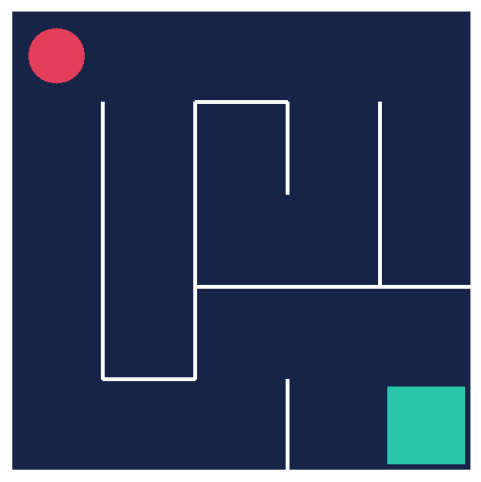

In [5]:
frame = env.render(mode='rgb_array')
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(frame)

In [6]:
print(f"Observation space: {env.observation_space}")
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space: MultiDiscrete([5 5])
Observation space shape: [5 5]
Number of actions: 4


## Define the policy $\pi(\cdot|s)$

#### Create the policy $\pi(\cdot|s)$

In [7]:
policy_probs = np.full((5, 5, 4), 0.25)

In [8]:
policy_probs

array([[[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]]])

In [9]:
policy_probs.shape

(5, 5, 4)

In [10]:
def policy(state):
    return policy_probs[state]

#### Test the policy with state (0, 0)

In [11]:
action_probabilities = policy((0,0))
for action, prob in zip(range(4), action_probabilities):
    print(f"Probability of taking action {action}: {prob}")

Probability of taking action 0: 0.25
Probability of taking action 1: 0.25
Probability of taking action 2: 0.25
Probability of taking action 3: 0.25


#### See how the random policy does in the maze

In [12]:
test_agent(env, policy, episodes=1)

#### Plot the policy

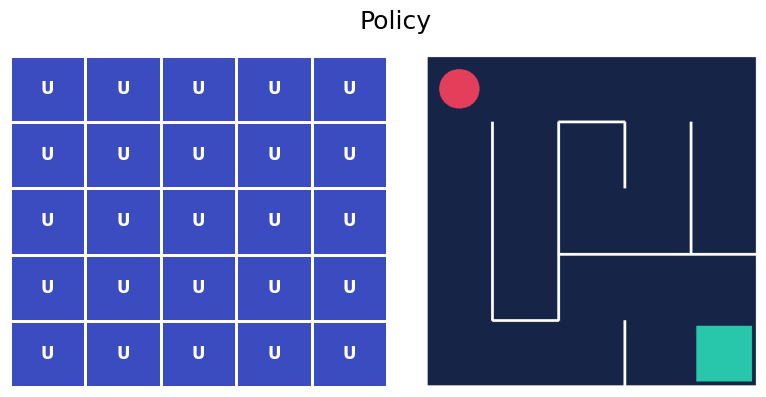

In [13]:
plot_policy(policy_probs, frame)

## Define value table $V(s)$

#### Create the $V(s)$ table

In [14]:
state_values = np.zeros(shape=(5,5))

#### Plot V(s)

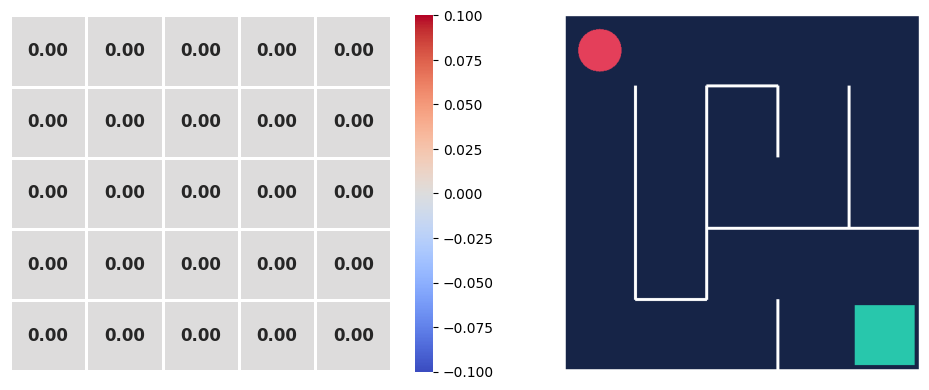

In [15]:
plot_values(state_values, frame)

## Implement the Value Iteration algorithm

</br>




<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>

In [16]:
def value_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):
    delta = float('inf')

    while delta > theta:
        delta = 0
        for row in range(5):
            for col in range(5):
                old_value = state_values[(row, col)]
                action_probs = None
                max_qsa = float('-inf')

                for action in range(4):
                    next_state, reward, _, _ = env.simulate_step((row, col), action)
                    qsa = reward + gamma * state_values[next_state]
                    if qsa > max_qsa:
                        max_qsa = qsa
                        action_probs = np.zeros(4)
                        action_probs[action] = 1.

                state_values[(row, col)] = max_qsa
                policy_probs[(row, col)] = action_probs

                delta = max(delta, abs(max_qsa - old_value))

In [17]:
value_iteration(policy_probs, state_values)

## Show results

#### Show resulting value table $V(s)$

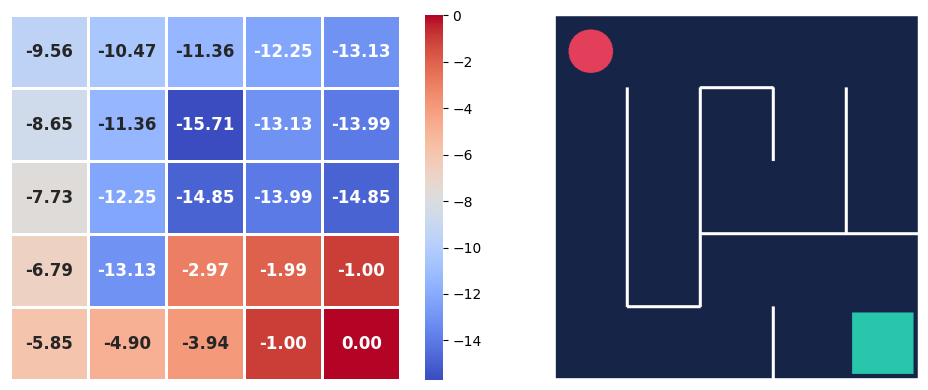

In [18]:
plot_values(state_values, frame)

#### Show resulting policy $\pi(\cdot|s)$

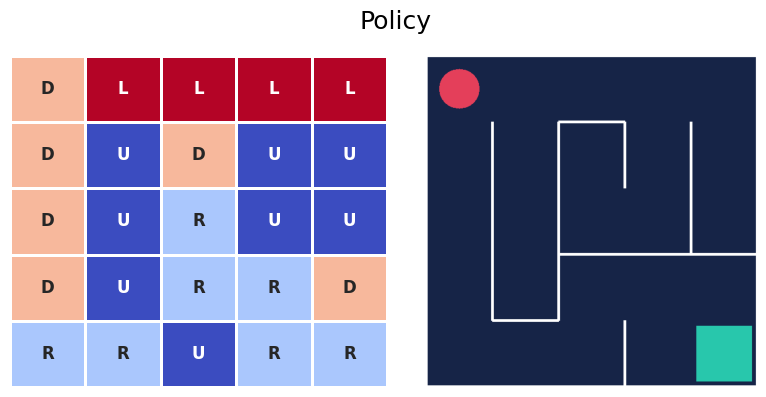

In [19]:
plot_policy(policy_probs, frame)

#### Test the resulting agent

In [20]:
test_agent(env, policy)

## Resources

CONCLUSION :
 In conclusion, the Value Iteration algorithm provides a systematic approach to finding optimal policies in Markov Decision Processes (MDPs). By iteratively updating the value of each state based on the maximum expected return achievable, the algorithm converges to the optimal values, guiding the agent towards making the best decisions in a given environment.

In the context of maze solving, Value Iteration proves to be a valuable tool. By representing the maze as an MDP and applying the algorithm, the agent can efficiently navigate through the maze to reach the goal while maximizing cumulative rewards. This approach enables the agent to learn the optimal policy for maze solving, even in complex maze layouts.

Overall, Value Iteration demonstrates its effectiveness in solving reinforcement learning problems where the environment dynamics are fully known and the state and action spaces are discrete. It serves as a foundation for various other reinforcement learning algorithms and continues to be a cornerstone in the field of artificial intelligence and decision-making systems.








[[1] Reinforcement Learning: An Introduction. Ch. 4: Dynamic Programming](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)